In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, SpatialDropout1D, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.initializers import Constant
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

In [3]:
#Cargamos dataset train en un dataframe
tweets_train = pd.read_csv('Dataset/train.csv')
tweets_test = pd.read_csv('Dataset/test.csv')
tweets_submission = pd.read_csv('Dataset/sample_submission.csv') 

In [4]:
tweets_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#Eliminamos los emojis del texto
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Almacenamos el texto limpio en una nueva feature del dataframe
tweets_train['cleaned_text']=tweets_train['text'].apply(lambda x: remove_emoji(x))
tweets_test['cleaned_text']=tweets_test['text'].apply(lambda x: remove_emoji(x))

In [6]:
#Eliminamos los numeros, url, simbolos y signos de puntuacion del texto 
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
tweets_train['cleaned_text'] = tweets_train['cleaned_text'].apply(lambda x: clean_text(x))
tweets_test['cleaned_text'] = tweets_test['cleaned_text'].apply(lambda x: clean_text(x))

In [8]:
#Stopwords
stop_words = stopwords.words('english') 
stops = r'\b({})\b'.format('|'.join(stop))

tweets_train['cleaned_text'] = tweets_train['cleaned_text'].str.replace(stops, '').str.replace('\s+', ' ')
tweets_test['cleaned_text'] = tweets_test['cleaned_text'].str.replace(stops, '').str.replace('\s+', ' ')

tweets_train.cleaned_text

0           deeds reason earthquake may allah forgive us 
1                   forest fire near la ronge sask canada
2        residents asked shelter place notified office...
3        people receive wildfires evacuation orders ca...
4        got sent photo ruby alaska smoke wildfires po...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                                      volcano hawaii 
7611    police investigating ebike collided car little...
7612     latest homes razed northern california wildfi...
Name: cleaned_text, Length: 7613, dtype: object

In [9]:
train_text_emb = tweets_train.cleaned_text
test_emb = tweets_test.cleaned_text
train_target_emb = tweets_train.target

In [10]:
#Tokenizer
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_text_emb)
vocab_length = len(word_tokenizer.word_index) + 1

In [11]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [12]:
longest_train = max(train_text_emb, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train_text_emb), length_long_sentence, padding='post')
test_sentences = pad_sequences(embed(test_emb), length_long_sentence, padding='post')

In [13]:
y = np.asarray(train_target_emb)

In [14]:
#Separamos al dataset tweets_train en un set de entrenamiento y uno de validacion, para text y para target
#El tamaño del set de validacion es del 25% del original
xTrain, xVal, yTrain, yVal = train_test_split(padded_sentences, y, test_size=0.25)

In [16]:
#GloVe
#Creacion de diccionario de palabras a partir del archivo preentrenado de GloVeembeddings_dictionary = dict()
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('Dataset/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [17]:
#Creacion de matriz de ocurrencias de palabras que se encuentran en los textos de los tweets
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
#Modelo de capas secuencial con BLSTM
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [25]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(xTrain,yTrain,epochs=10,batch_size=32, validation_data=(xVal, yVal), verbose = 1, callbacks = [checkpoint, reduce_lr])

Epoch 1/10
179/179 [==============================] - ETA: 0s - loss: 0.8183 - accuracy: 0.5595
Epoch 00001: val_loss improved from inf to 0.66060, saving model to model.h5
179/179 [==============================] - 7s 39ms/step - loss: 0.8183 - accuracy: 0.5595 - val_loss: 0.6606 - val_accuracy: 0.7017
Epoch 2/10
178/179 [============================>.] - ETA: 0s - loss: 0.6265 - accuracy: 0.6633
Epoch 00002: val_loss improved from 0.66060 to 0.53588, saving model to model.h5
179/179 [==============================] - 6s 36ms/step - loss: 0.6261 - accuracy: 0.6635 - val_loss: 0.5359 - val_accuracy: 0.7815
Epoch 3/10
179/179 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.7325
Epoch 00003: val_loss improved from 0.53588 to 0.46813, saving model to model.h5
179/179 [==============================] - 6s 36ms/step - loss: 0.5623 - accuracy: 0.7325 - val_loss: 0.4681 - val_accuracy: 0.8015
Epoch 4/10
178/179 [============================>.] - ETA: 0s - loss: 0.5096 

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 100)           1664400   
_________________________________________________________________
bidirectional (Bidirectional (None, 23, 46)            22816     
_________________________________________________________________
global_max_pooling1d (Global (None, 46)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 46)                184       
_________________________________________________________________
dropout (Dropout)            (None, 46)                0         
_________________________________________________________________
dense (Dense)                (None, 23)                1081      
_________________________________________________________________
dropout_1 (Dropout)          (None, 23)                0

In [29]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

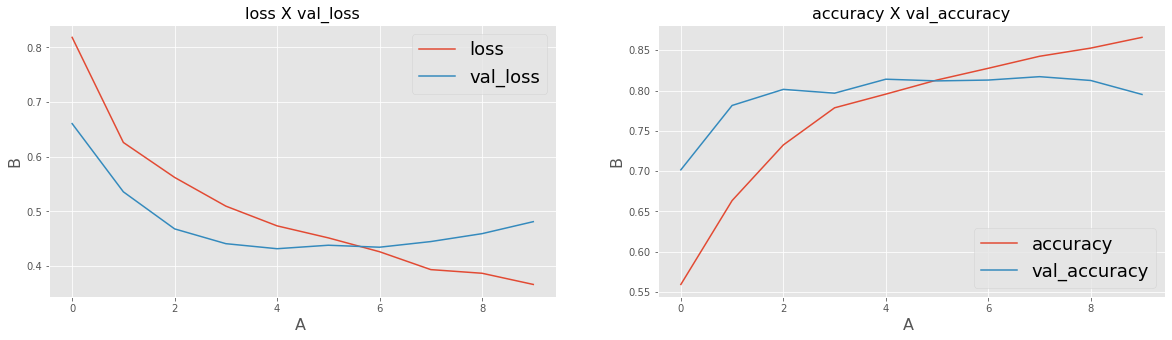

In [30]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [32]:
model.load_weights('model.h5')

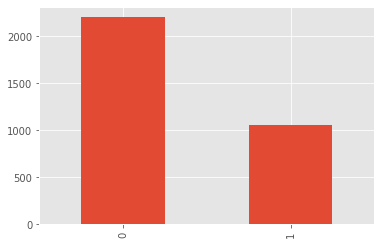

In [33]:
plt.figure(figsize=(10,7))
g = sns.barplot(x= tweets_submission.target.value_counts().index, y= tweets_submission.target.value_counts().values, orient='v', palette= 'husl', hue= tweets_submission.target.value_counts().index, dodge=False)
g.set_title("Tweets Test", fontsize=22)
g.set_xlabel("Tipo de noticia", fontsize=16)
g.set_ylabel("Cantidad de tweets", fontsize=16)

In [ ]:
tweets_submission.target = model.predict_classes(test_sentences)
tweets_submission.to_csv("submission.csv", index=False)